In [1]:
import wave
import json
import librosa
import csv
import numpy as np
from pywt import wavedec
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt

2023-11-05 23:21:16.130057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 23:21:16.166938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 23:21:16.166975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 23:21:16.167004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 23:21:16.173931: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 23:21:16.174766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [24]:
model_uri = '../modelh5/model_cnn_tuning.h5'
new_model = tf.keras.models.load_model(model_uri)
new_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 110, 64)           256       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 55, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 53, 32)            6176      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 27, 32)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 864)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

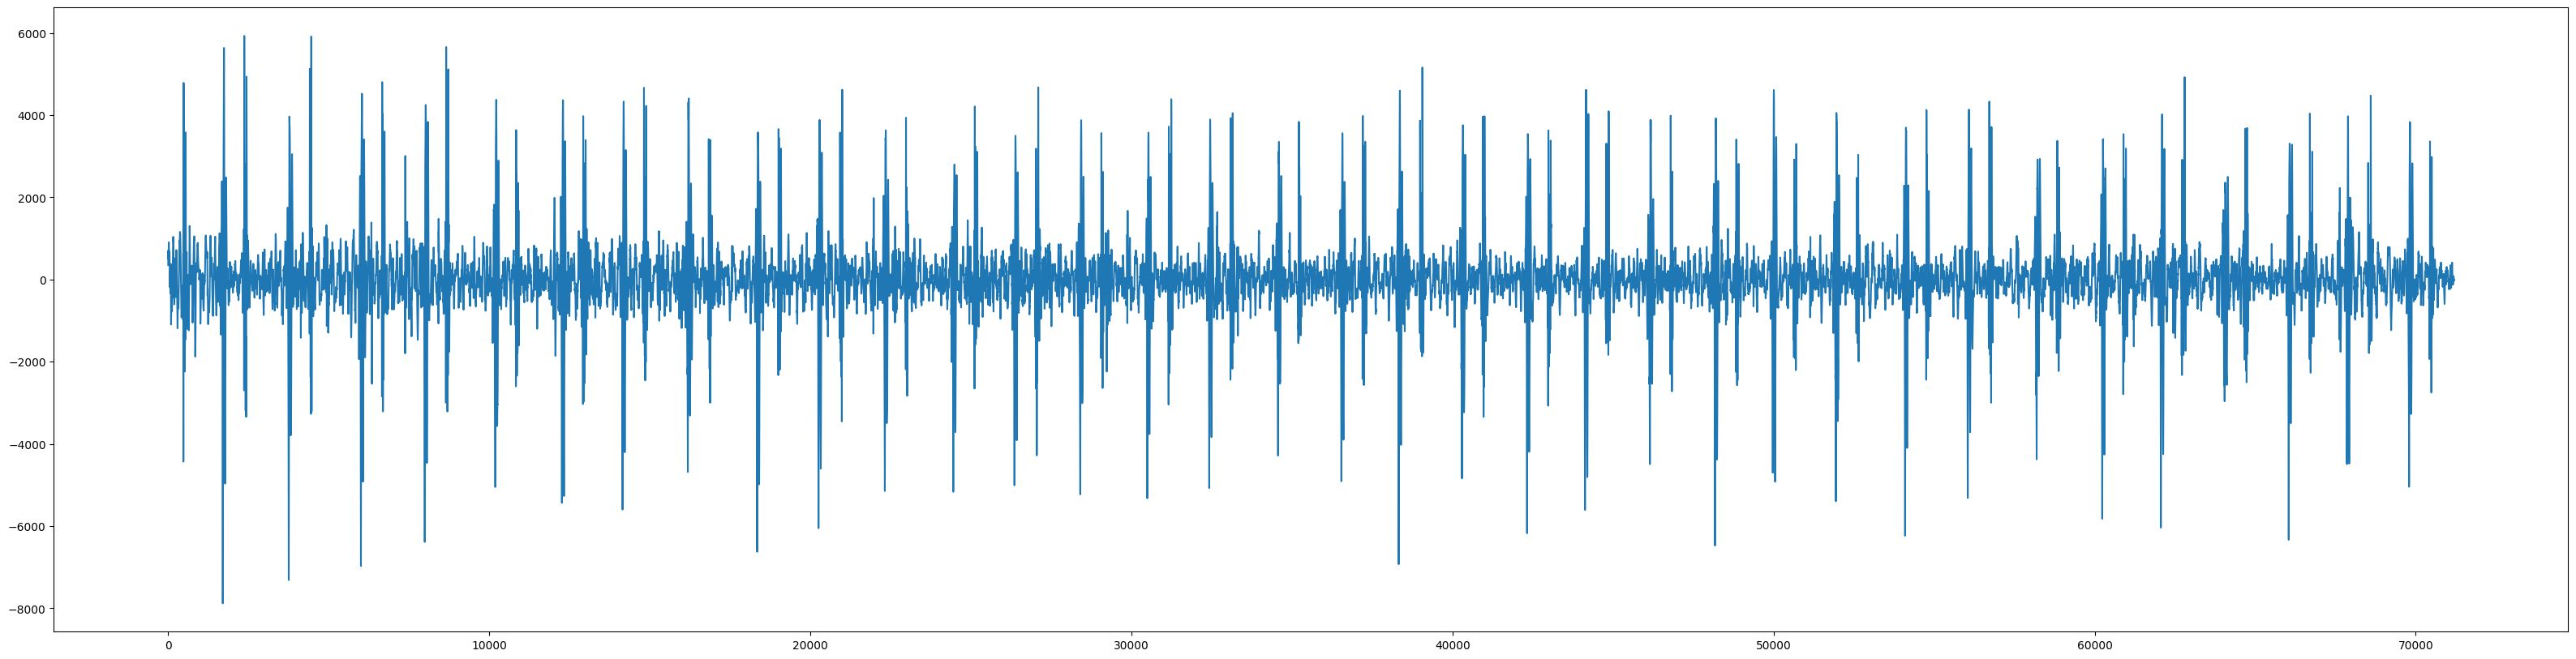

In [28]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import pywt
import seaborn as sns
samplerate, data = wavfile.read('./a0004.wav')
plt.figure(figsize=(40,10))
sns.lineplot(data=data)
plt.show()

In [29]:
samplerate, data = wavfile.read('./a0004.wav');  # Reading the audio file
t = np.arange(len(data)) / float(samplerate);  # Retrieving Time

print("data -> ", data)
print("data length -> ", len(data))
print("np.arange(len(data)) -> ", np.arange(len(data)))
print("float(samplerate) -> ", float(samplerate))
print("time -> ", t)

data = data/max(data);  # Normalize Audio Data
print("normalized data -> ", data)

cA, cD = pywt.dwt(data, 'bior6.8', 'per') # ini DWT
y = pywt.idwt(cA, cD, 'bior6.8', 'per') # ini IDWT
wavfile.write('new_4.wav', samplerate, y) # save y

data ->  [350 703 599 ...  -2 -13 -13]
data length ->  71193
np.arange(len(data)) ->  [    0     1     2 ... 71190 71191 71192]
float(samplerate) ->  2000.0
time ->  [0.00000e+00 5.00000e-04 1.00000e-03 ... 3.55950e+01 3.55955e+01
 3.55960e+01]
normalized data ->  [ 0.0590518   0.11860975  0.10106293 ... -0.00033744 -0.00219335
 -0.00219335]


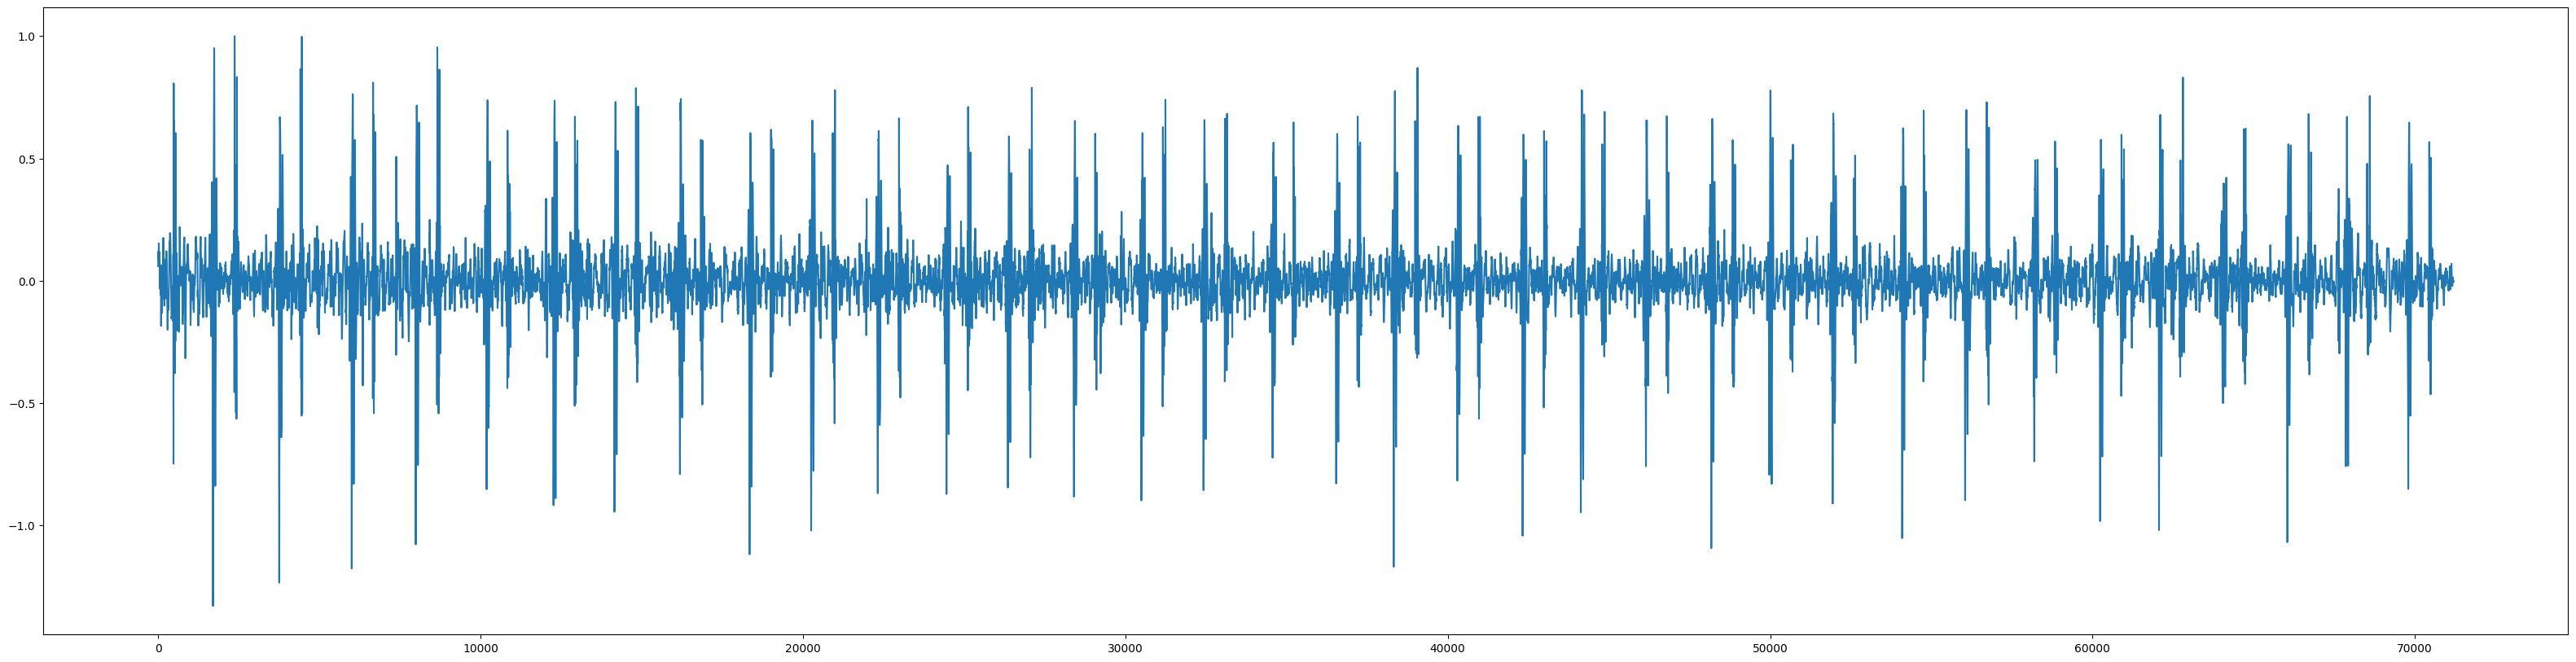

In [30]:
samplerate, data = wavfile.read('./new_4.wav')
plt.figure(figsize=(40,10))
sns.lineplot(data=data)
plt.show()

In [32]:
# trim wav to 5 seconds
from pydub import AudioSegment
from pydub.utils import make_chunks

myaudio = AudioSegment.from_file("./new_4.wav" , "wav")
chunk_length_ms = 5000 # pydub calculates in millisec
chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

#Export all of the individual chunks as wav files
for i, chunk in enumerate(chunks):
    chunk_name = "./chunk{0}.wav".format(i)
    print ("exporting", chunk_name)
    chunk.export(chunk_name, format="wav")

exporting ./chunk0.wav


Error: bad sample width

In [34]:
import wave
import json
header = 'filename'
for i in range(1, 41):
    header += f' mfcc{i}'
for i in range(1, 13):
  header += f' chroma{i}'
for i in range(1, 61):
  header += f' cqt{i}'
header += ' label'
header = header.split()


def extract_mfcc(audiofile):
    file = open('test.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    y, sr = librosa.load(audiofile, mono=True, duration=3, sr=8000)
    coeffs = wavedec(y, 'db1', level=10)
    cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD1, cD1 = coeffs
    mfcc = librosa.feature.mfcc(y=cD1, sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
    rms = librosa.feature.chroma_stft(y=cD1, sr=8000)
    cqt = np.abs(librosa.cqt(y=cD1, sr=sr, n_bins=60))
    combined_features = np.concatenate((mfcc, rms, cqt), axis=0)
    to_append = f'Signal'
    for e in combined_features:
        to_append += f' {np.mean(e.T, axis=0)}'
    file = open('test.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

def predict(audio):
    model = tf.keras.models.load_model(model_uri)
    extract_mfcc(audio)
    data = pd.read_csv('test.csv')
    # scaler = StandardScaler()
    df = data.drop(['label', 'filename'], axis=1)
    pred = model.predict(df)
    class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
    cek = np.argmax(pred[0])
    # print(pred[0])
    # print(cek)
    print("=====")
    print(audio)
    print(f'Predicted class: {class_labels[cek]}')
    print("=====")

predict('./a0019.wav')


1/1 [==============================] - 0s 96ms/step
=====
./a0019.wav
Predicted class: N
=====
